### To make arms context dependant, context should be both positive and negative!

To make them so need to rewrite state enumeration in SimOOS

# Synthetic dataset creation

In this notebook I create a synthetic dataset to test the proposed bandit algorithm and compare it to benchmarks.
Synthetic dataset will have following features:
- 10,000 time points
- At each time $t$ the environment generates a context vector $x_t$ of dimension 6. Each feature $x_t^{(i)}$ is **categorical**, and lies in range(1,feature_size). This is needed for the `state_extract` function in SimOOS to correctly number all the states.
- Each context vector $x_t$ is associated with a cost vector $c_t$. Cost of each feature $c_t^{i}$ follows a Gaussian distribution with fixed standard deviation and **piecewise-constant** mean lying in range $[0; 0.07]$. Change-points of costs are different from change points of rewards.
- A fixed (for all $t$) set $\mathcal{A}$ of 5 arms are available for the algorithm to choose from.
- Rewards associated with each arm and context follow a Bernoulli distribution, parametrized by $p = \sigma(\bar{x_t}^T\theta_{t,a})$. Here $\bar{x_t}$ is not context observed at time t, but rather it is expected context inside one stationarity interval.  Also $\sigma()$ is the sigmoid function and $\theta_{t,a}$ is the ground truth bandit parameter (not disclosed to the algorithm) associated with each arm $a_i$ at time $t$. Bandit parameter satisfies condition $\lVert\theta_{t,a}\rVert_2 \le 1$.  For each arm $a_i$, parameter $\theta_{t,a}$ is piecewise-constant and thus the corresponding **generating process of rewards is piecewise-stationary** with change points every 2000 steps.
This method of generating rewards from contexts follows [1] and [2], but instead of Gaussian reward with mean $x_t^T\theta_{t,a}$ the reward is Bernoulli with parameter $\sigma(\bar{x_t}^T\theta_{t,a})$

[1] Learning Contextual Bandits in a Non-stationary Environment, Wu et al.

[2] Contextual-Bandit Based Personalized Recommendation with Time-Varying User Interests, Xu et al.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [4]:
TIME_POINTS = 10000
NUM_FEATURES = 5
N_ARMS = 5

## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1,2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1,2,3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
feature_config = {
    0: {
        'values': [-2, -1, 0, 1,2,],
        'distribution': [0.25]*5,
    },
    1: {
        'values': [-1,1],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [-1, 0, 1],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [-1, 0, 1, 2],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [-2,-1,0,1,2],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [-1,0],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [9]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [10]:
contexts, contexts.shape

(array([[ 1.,  1., -1.,  2.,  2.],
        [ 1.,  1.,  0.,  2.,  0.],
        [-1.,  1.,  0.,  1., -1.],
        ...,
        [-1.,  1., -1.,  0., -2.],
        [ 0.,  1., -1.,  1., -1.],
        [ 0.,  1.,  0.,  0., -1.]]),
 (10000, 5))

### Visualizing context features

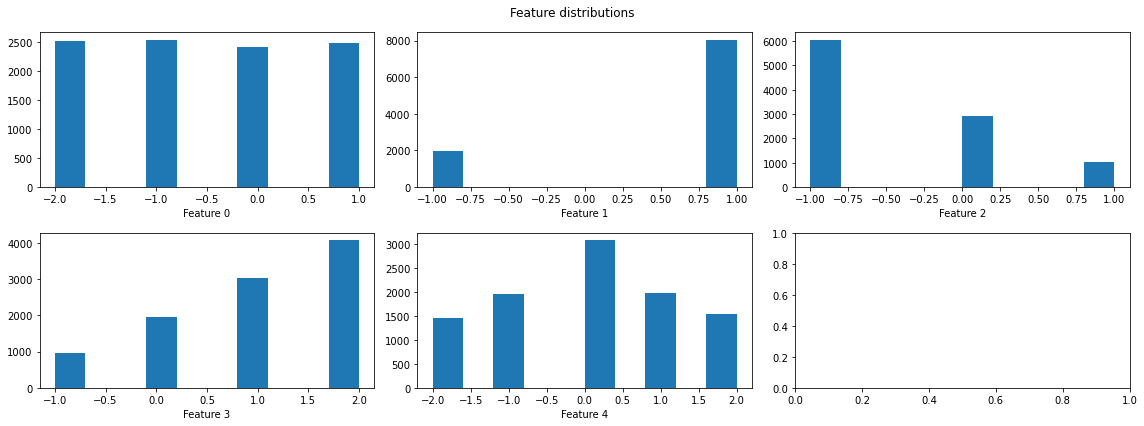

In [11]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [12]:
# Mean of gaussian distribution random in interval [0, 0.1] 
interval_means = [np.random.uniform(0, 0.0005, size=(NUM_FEATURES,)) for i in range(5)]

In [13]:
# Fixed std
interval_stds = [[0.0005]*NUM_FEATURES]*5

In [14]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

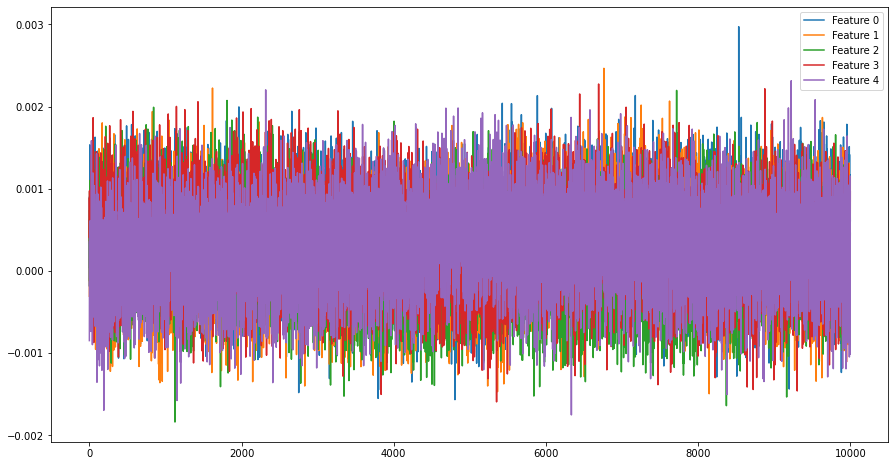

In [15]:
plot_costs(get_costs(), 10000)

In [16]:
costs_obj = get_costs()

In [17]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [18]:
costs_vector.shape

(10000, 5)

## Creating rewards

In [19]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [20]:
slices = [
    slice(0,2000),
    slice(2000,4000),
    slice(4000,6000),
    slice(6000,8000),
    slice(8000,10000),
]

In [21]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [22]:
np.random.seed(42)

In [23]:
# Separate all timesteps into slices. For each slice and for each arm generate ground truth bandit parameter theta.
# Take dot product of theta with expected context and put this through sigmoid to get p for Bernoulli distribution. 
# Sample reward for each slice and arm from this distribution.

# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    for arm in range(N_ARMS):
        # Ground truth bandit parameter for given arm. These parameters are piecewise-constant.
        random_vec = np.random.normal(size=NUM_FEATURES)
        theta = random_vec / np.linalg.norm(random_vec)

        expected_context = np.mean(context_slice, axis=0)
        z = context_slice @ theta
        
        # Parameter of bernoulli distribution of rewards for this slice and arm.
        p = sigmoid(z)
        
        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p)
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )


    

Slice 0:
  Arm 0: p=0.61, mean reward=0.62   reward estimated by linear regression 0.47
  Arm 1: p=0.64, mean reward=0.64   reward estimated by linear regression 0.50
  Arm 2: p=0.59, mean reward=0.59   reward estimated by linear regression 0.45
  Arm 3: p=0.42, mean reward=0.42   reward estimated by linear regression 0.27
  Arm 4: p=0.60, mean reward=0.61   reward estimated by linear regression 0.46
Slice 1:
  Arm 0: p=0.47, mean reward=0.46   reward estimated by linear regression 0.31
  Arm 1: p=0.55, mean reward=0.54   reward estimated by linear regression 0.39
  Arm 2: p=0.34, mean reward=0.34   reward estimated by linear regression 0.18
  Arm 3: p=0.58, mean reward=0.59   reward estimated by linear regression 0.43
  Arm 4: p=0.52, mean reward=0.51   reward estimated by linear regression 0.36
Slice 2:
  Arm 0: p=0.32, mean reward=0.32   reward estimated by linear regression 0.18
  Arm 1: p=0.37, mean reward=0.37   reward estimated by linear regression 0.23
  Arm 2: p=0.63, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_89742/395065202.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


In [24]:
rewards.shape

(10000, 5)

In [25]:
costs_vector.shape

(10000, 5)

## Testing algorithms on synthetic data

In [26]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

In [27]:
NUM_OF_TRIALS = 10000

In [28]:
p_random = algorithms.RandomPolicy()
gain_random = evaluation.evaluate_on_synthetic_data(
    p_random,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Random policy
Total gain: 5161.0
	Total reward: 5161.0
	Total cost: 0
Execution time: 0.1s


In [29]:
egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=rewards.shape[1])

gain_egreedy = evaluation.evaluate_on_synthetic_data(
    egreedy,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

E-greedy(epsilon=0.01)
Total gain: 5117.0
	Total reward: 5117.0
	Total cost: 0
Execution time: 0.1s


In [30]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=0.4,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

UCB1 (α=0.4)
Total gain: 6279.0
	Total reward: 6279.0
	Total cost: 0
Execution time: 0.1s


In [31]:
linucb = algorithms.LinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=0.4,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

LinUCB (alpha=0.4)
Total gain: 5796.310820521325
	Total reward: 5811.0
	Total cost: 14.689179478703723
Execution time: 0.3s


In [32]:
ps_linucb = algorithms.PSLinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=0.3,
    omega=200,
    delta=0.1,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points

PSLinUCB (alpha=0.3, omega=200, delta=0.1)
Total gain: 6289.310820521325
	Total reward: 6304.0
	Total cost: 14.689179478703723
Execution time: 0.8s


In [33]:
s = time.time()
p_simoos = algorithms.SimOOSAlgorithm(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=1,
    delta_SimOOS=0.1,
)
print(f"Took {time.time() - s} seconds")

Took 0.06096696853637695 seconds


In [34]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_simoos = evaluation.evaluate_on_synthetic_data(
        p_simoos,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Round 500, time 2022-03-11 11:20:58.820401
Round 1000, time 2022-03-11 11:22:24.186717
Round 1500, time 2022-03-11 11:23:49.488231
Round 2000, time 2022-03-11 11:25:13.995253
Round 2500, time 2022-03-11 11:26:38.710546
Round 3000, time 2022-03-11 11:28:03.326435
Round 3500, time 2022-03-11 11:29:28.733566
Round 4000, time 2022-03-11 11:30:54.691848
Round 4500, time 2022-03-11 11:32:20.023414
Round 5000, time 2022-03-11 11:33:46.770920
Round 5500, time 2022-03-11 11:35:14.710632
Round 6000, time 2022-03-11 11:36:43.396898
Round 6500, time 2022-03-11 11:38:10.781042
Round 7000, time 2022-03-11 11:39:35.944749
Round 7500, time 2022-03-11 11:41:01.369173
Round 8000, time 2022-03-11 11:42:27.323315
Round 8500, time 2022-03-11 11:43:53.762680
Round 9000, time 2022-03-11 11:45:19.014569
Round 9500, time 2022-03-11 11:46:45.247999
SimOOS (beta=1, delta=0.1)
Total gain: 4915.307059043777
	Total reward: 4925.0
	Total cost: 9.692940956216866
Execution time: 28.6m
Took 1713.1123609542847 seconds


In [35]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
        
    max_vline=0
    
    for label, gain in gain_dict.items():
        ax.plot(gain, label=label)
        max_vline=max(max_vline, max(gain))
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cumulative gain')
    ax.set_title('Evaluation on synthetic data')
    
    ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

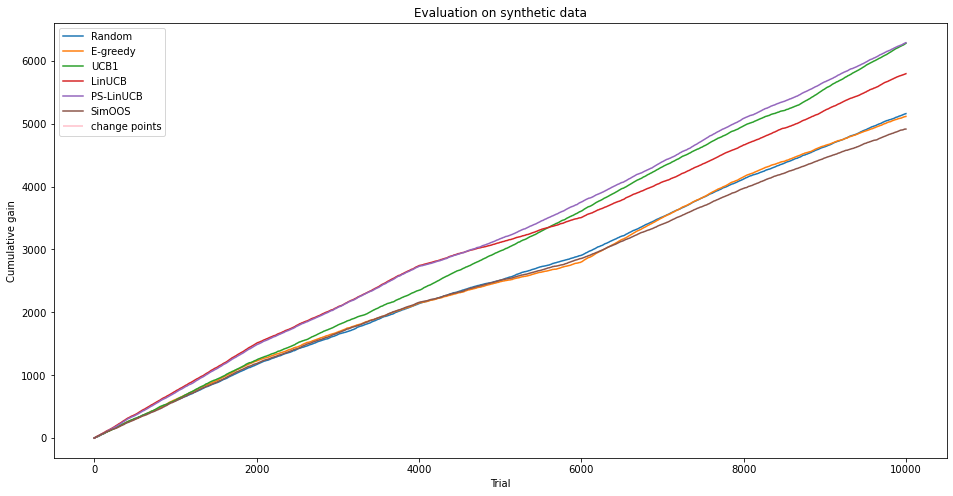

In [36]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
},
)
